In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import pandas as pd
import csv
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
! pip install evaluate
import evaluate
import torch
from sklearn.model_selection import train_test_split
# Move tensors to GPU if device is CUDA
from transformers import Trainer, TrainingArguments, AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset
import torch

2025-09-24 12:20:51.276175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758716451.299562     172 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758716451.306625     172 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Model name on Hugging Face Hub
model_name =  "bert-base-multilingual-cased"

# Download tokenizer + weights
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=5)

print("✅ mBERT downloaded and ready!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ mBERT downloaded and ready!


In [3]:
# path = "/kaggle/input/complaints/Dataset complaint Management System (1).csv"

# df = pd.read_csv(
#     path,
#     encoding="cp1256",
#     sep=",",                  # change if your delimiter is not comma
#     engine="python",
#     quoting=csv.QUOTE_NONE,   # don't treat quotes specially
#     escapechar="\\",          # allow \" inside fields
#     on_bad_lines="skip"
# )

In [4]:
import pandas as pd

path = r"/kaggle/input/data56/Dataset complaint Management System (2).csv"

def load_any_table(path):
    # Peek first few bytes to detect XLSX/ZIP
    with open(path, "rb") as f:
        sig = f.read(4)
    is_zip = sig == b"PK\x03\x04"  # XLSX is a zip

    if is_zip:
        # It's actually an Excel file with a wrong extension
        return pd.read_excel(path, engine="openpyxl")
    else:
        # It's a real CSV
        for enc in ["utf-8-sig", "cp1256", "ISO-8859-1"]:
            try:
                return pd.read_csv(
                    path,
                    encoding=enc,
                    sep=",",
                    engine="python",
                    quotechar='"',
                    doublequote=True,
                    escapechar="\\",
                    on_bad_lines="skip",
                    skipinitialspace=True,
                )
            except Exception:
                continue
        raise RuntimeError("Could not parse as CSV with common encodings.")

df = load_any_table(path)
TEXT_COL = "ComplaintText"   # <-- change to exact name
LABEL_COL = "Category"        # <-- change to exact name

# Keep only those two
df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)

# Rename to standard names
df = df.rename(columns={TEXT_COL: "text", LABEL_COL: "labels"})

print(df.shape)
print(df.head(38))

(4061, 2)
                                                 text                  labels
0   Access to certain buildings is restricted with...    Facilities_Logistics
1          Access to supplementary videos is blocked.       Coursers_Training
2   Administrative emails are not replied to promp...  Certificates_Documents
3   Administrative office does not respond to urge...  Certificates_Documents
4   Administrative office hours are not updated on...  Certificates_Documents
5   Administrative staff is slow to approve certif...  Certificates_Documents
6   Administrative staff response is inconsistent ...  Certificates_Documents
7        Approval process for internships is delayed.  Certificates_Documents
8     Assignment deadlines are unclear in the portal.       Coursers_Training
9     Assignment extensions are not reflected in LMS.       Coursers_Training
10  Assignment file formats are not compatible wit...       Coursers_Training
11   Assignment reminders are not sent automatically. 

In [5]:
from sklearn.preprocessing import LabelEncoder

# Label encoding the labels
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['labels'])

# Show the label encoding
print(label_encoder.classes_)


['Certificates_Documents' 'Coursers_Training' 'Facilities_Logistics'
 'Finance_Admin' 'IT_Support ']


In [6]:
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} → {idx}")

Certificates_Documents → 0
Coursers_Training → 1
Facilities_Logistics → 2
Finance_Admin → 3
IT_Support  → 4


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [8]:
from sklearn.model_selection import train_test_split
import torch
from datasets import Dataset

# Split the data into train (80%), validation (10%), and test (10%)

# Split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert to HF datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset   = Dataset.from_pandas(val_df)
test_dataset  = Dataset.from_pandas(test_df)

# Tokenizer function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset   = val_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

# Keep only model-required columns
cols = ["input_ids", "attention_mask", "labels"]
if "token_type_ids" in train_dataset.column_names:
    cols.append("token_type_ids")

train_dataset = train_dataset.with_format("torch", columns=cols)
val_dataset   = val_dataset.with_format("torch", columns=cols)
test_dataset  = test_dataset.with_format("torch", columns=cols)

# Model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(len(train_dataset), len(val_dataset), len(test_dataset))

Map:   0%|          | 0/3248 [00:00<?, ? examples/s]

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

Map:   0%|          | 0/407 [00:00<?, ? examples/s]

3248 406 407


In [9]:
print(train_dataset.column_names)

['text', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


In [10]:
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} → {idx}")
print('Train_Dataset:',train_df['labels'].value_counts())

Certificates_Documents → 0
Coursers_Training → 1
Facilities_Logistics → 2
Finance_Admin → 3
IT_Support  → 4
Train_Dataset: labels
4    799
1    681
3    607
0    596
2    565
Name: count, dtype: int64


In [11]:
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} → {idx}")
print('val_Dataset:',val_df['labels'].value_counts())

Certificates_Documents → 0
Coursers_Training → 1
Facilities_Logistics → 2
Finance_Admin → 3
IT_Support  → 4
val_Dataset: labels
4    94
2    91
1    82
3    70
0    69
Name: count, dtype: int64


In [12]:
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} → {idx}")
print('Test_Dataset:',test_df['labels'].value_counts())

Certificates_Documents → 0
Coursers_Training → 1
Facilities_Logistics → 2
Finance_Admin → 3
IT_Support  → 4
Test_Dataset: labels
4    102
0     81
1     77
2     75
3     72
Name: count, dtype: int64


In [13]:
from transformers import DataCollatorWithPadding

# Create a data collator to batch data correctly
ddata_collator = DataCollatorWithPadding(tokenizer)


In [14]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True


In [15]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🔢 Total parameters: {total_params:,}")
print(f"🟢 Trainable parameters: {trainable_params:,}")
print(f"🟡 Frozen parameters: {total_params - trainable_params:,}")

🔢 Total parameters: 177,857,285
🟢 Trainable parameters: 177,857,285
🟡 Frozen parameters: 0


In [16]:
!pip uninstall -y wandb

from transformers import Trainer, TrainingArguments
import evaluate

# Load metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Define the compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)  # Convert logits to class predictions
    
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    # average="weighted" مناسب لو عندك classes غير متوازنة
    
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",          
    num_train_epochs=2,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,

    # ✅ extras to avoid save errors
    save_strategy="no",
    save_total_limit=1,              
    metric_for_best_model="f1",   # ممكن تختار f1 بدل accuracy لو أهم
    greater_is_better=True,
    report_to=None                   
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=ddata_collator
)

# Train the model
trainer.train()



# Evaluate on validation, test, and train sets
eval_results = trainer.evaluate(val_dataset)
print(f"Validation results: {eval_results}")

test_results = trainer.evaluate(test_dataset)
print(f"Test results: {test_results}")

train_results = trainer.evaluate(train_dataset)
print(f"Train results: {train_results}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/tmp/ipykernel_172/3324975632.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.612900
20,1.610000
30,1.593200
40,1.455800
50,1.309000
60,1.057400
70,1.142600
80,0.939000
90,0.776900
100,0.909600


Validation results: {'eval_loss': 0.30916914343833923, 'eval_accuracy': 0.916256157635468, 'eval_f1': 0.9154161878402753, 'eval_runtime': 6.5432, 'eval_samples_per_second': 62.049, 'eval_steps_per_second': 3.974, 'epoch': 2.0}
Test results: {'eval_loss': 0.3955148756504059, 'eval_accuracy': 0.8894348894348895, 'eval_f1': 0.8887702953554555, 'eval_runtime': 6.5532, 'eval_samples_per_second': 62.107, 'eval_steps_per_second': 3.968, 'epoch': 2.0}
Train results: {'eval_loss': 0.16173388063907623, 'eval_accuracy': 0.9488916256157636, 'eval_f1': 0.948399973132721, 'eval_runtime': 50.9455, 'eval_samples_per_second': 63.754, 'eval_steps_per_second': 3.985, 'epoch': 2.0}


In [17]:
# Save model to one folder
model.save_pretrained("my_model_dir")

# Save tokenizer to another folder
tokenizer.save_pretrained("my_tokenizer_dir")


('my_tokenizer_dir/tokenizer_config.json',
 'my_tokenizer_dir/special_tokens_map.json',
 'my_tokenizer_dir/vocab.txt',
 'my_tokenizer_dir/added_tokens.json',
 'my_tokenizer_dir/tokenizer.json')

In [18]:
class_names = list(label_encoder.classes_)
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_conf_matrix_per_class(y_true, y_pred, class_names=None, split_name=""):
    classes = np.unique(y_true)
    for c in classes:
        # Binary view: this class vs all others
        y_true_bin = (y_true == c).astype(int)
        y_pred_bin = (y_pred == c).astype(int)

        cm = confusion_matrix(y_true_bin, y_pred_bin)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=[f"Not {class_names[c]}", class_names[c]] 
            if class_names is not None else ["Other", str(c)]
        )
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title(f"Confusion Matrix — {split_name} — Class {class_names[c] if class_names else c}")
        plt.show()




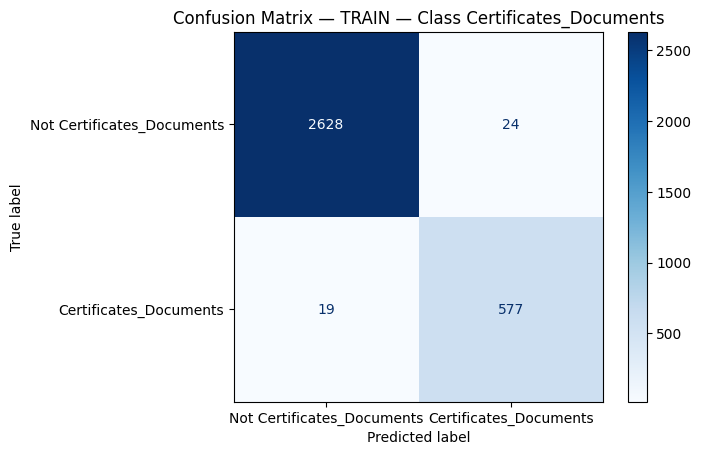

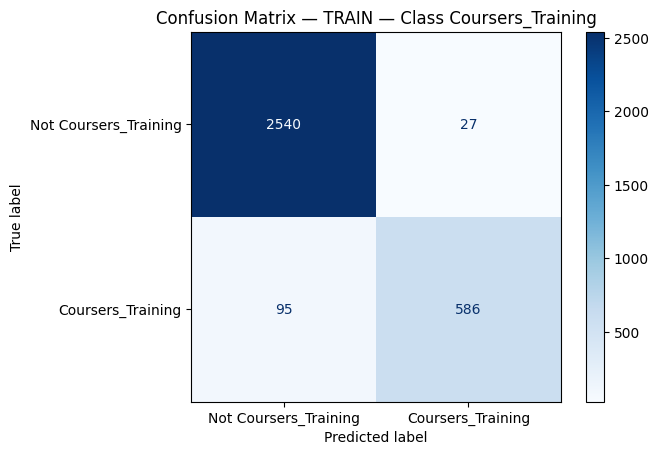

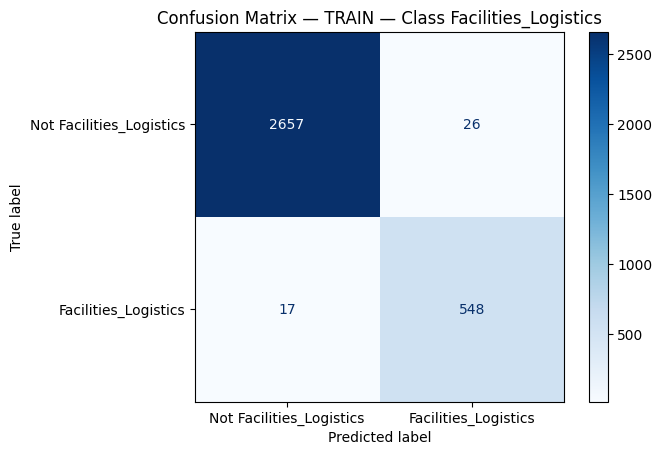

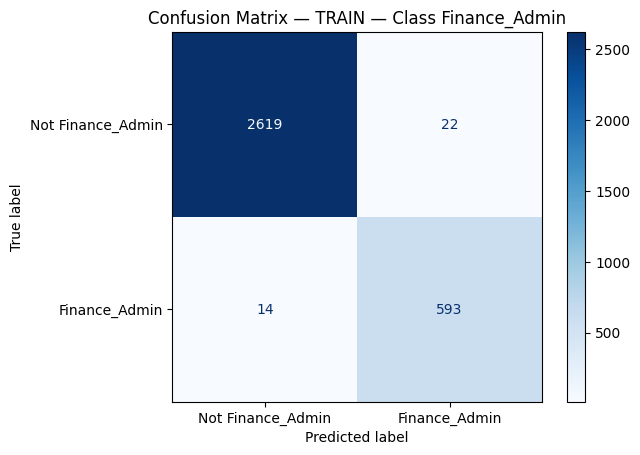

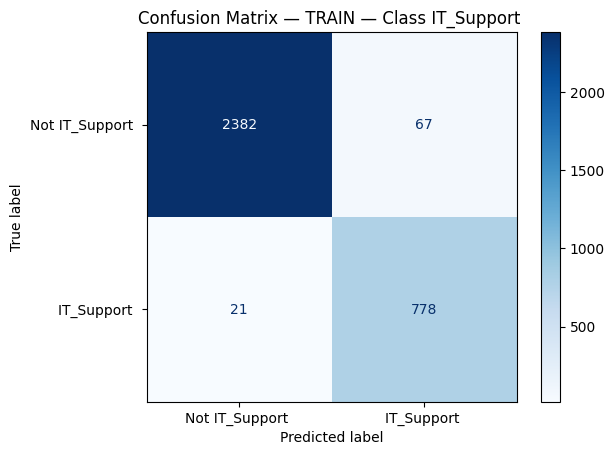

In [19]:
# --- TRAIN ---
pred_train = trainer.predict(train_dataset)
y_true_train = pred_train.label_ids
y_pred_train = pred_train.predictions.argmax(axis=1)
plot_conf_matrix_per_class(y_true_train, y_pred_train, class_names, split_name="TRAIN")


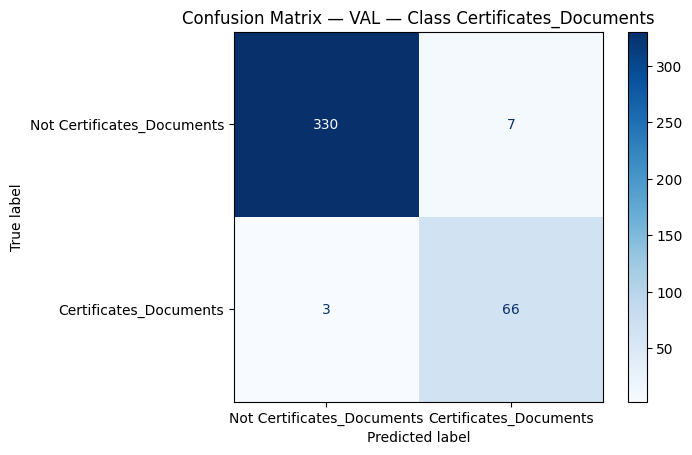

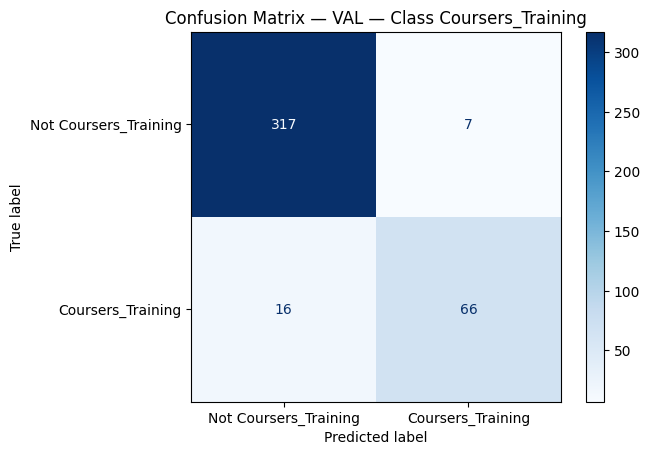

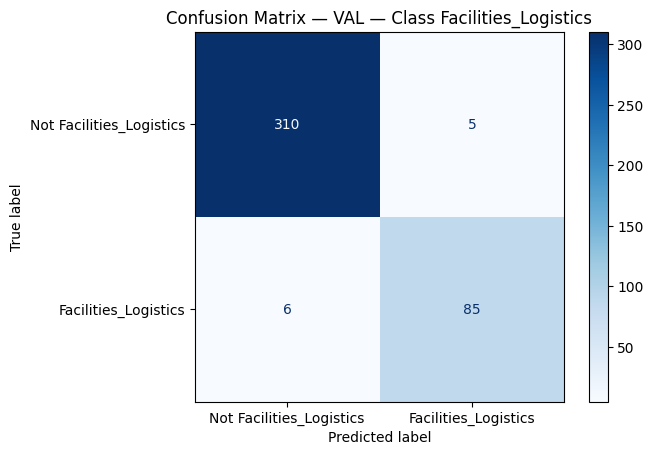

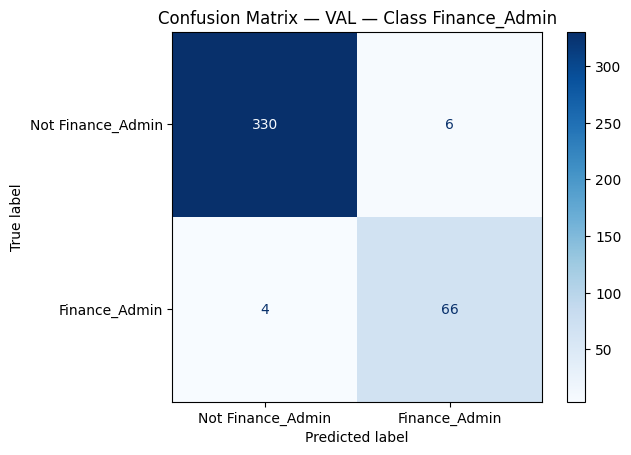

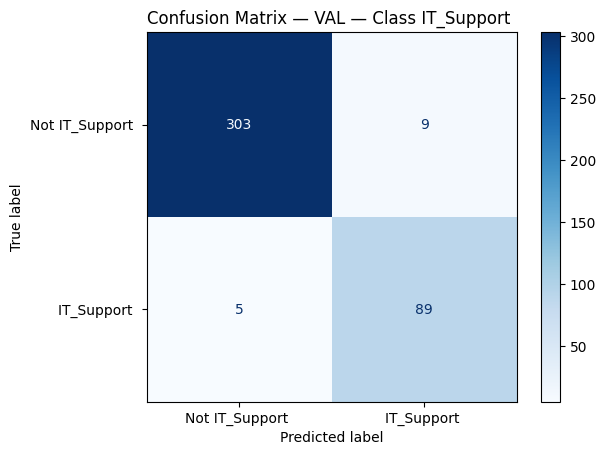

In [20]:
# --- VAL ---
pred_val = trainer.predict(val_dataset)
y_true_val = pred_val.label_ids
y_pred_val = pred_val.predictions.argmax(axis=1)
plot_conf_matrix_per_class(y_true_val, y_pred_val, class_names, split_name="VAL")


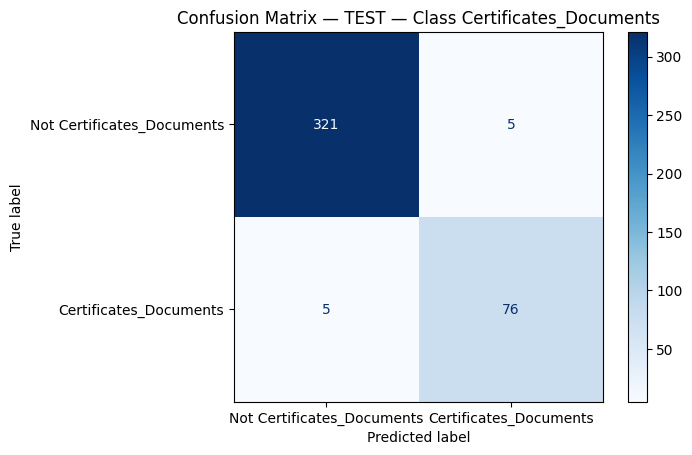

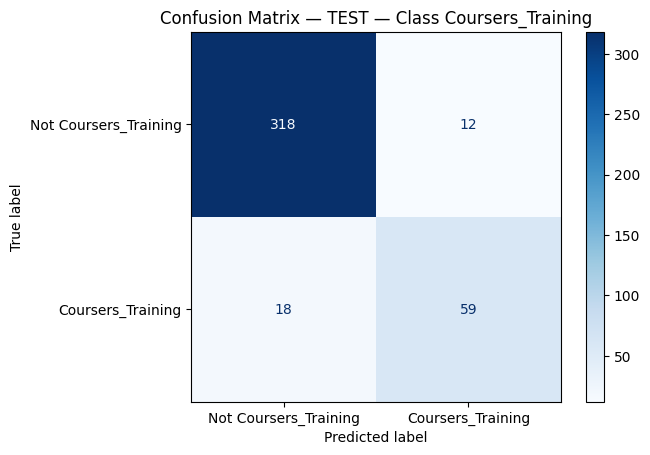

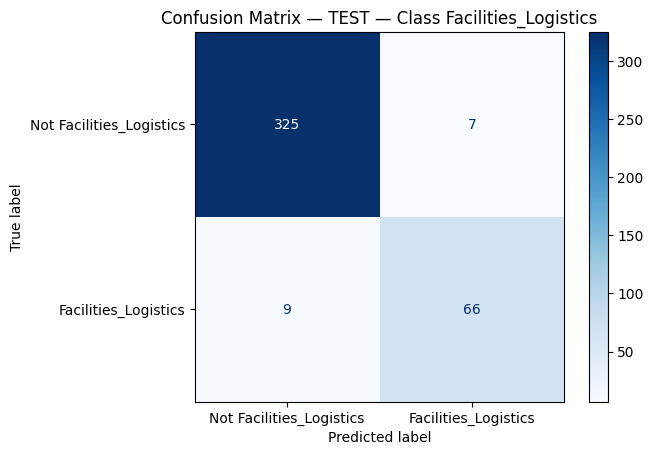

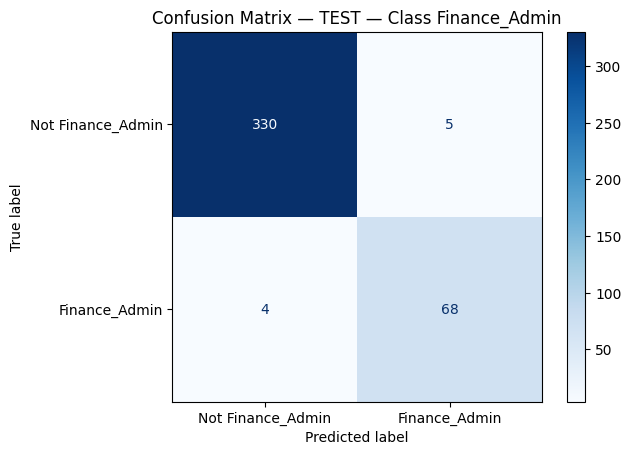

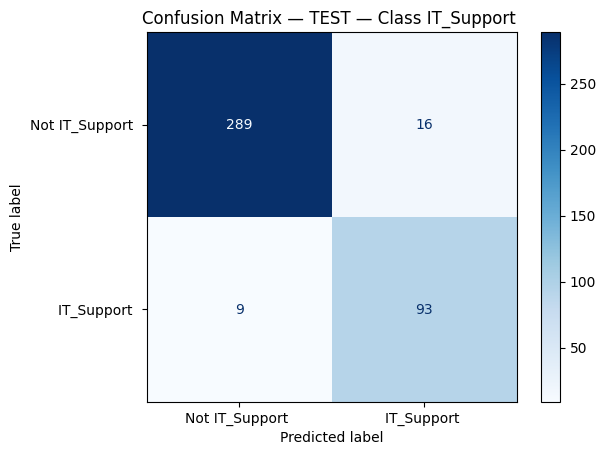

In [21]:
# --- TEST ---
pred_test = trainer.predict(test_dataset)
y_true_test = pred_test.label_ids
y_pred_test = pred_test.predictions.argmax(axis=1)
plot_conf_matrix_per_class(y_true_test, y_pred_test, class_names, split_name="TEST")
